In [1]:
import wobble
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = wobble.Data('hip54287_e2ds.hdf5', filepath='data/', orders=[56])

In [3]:
model = wobble.Model(data)
model.add_star('hip54287b')
model.add_telluric('tellurics')
print(model)

Model consisting of the following components: ['a', 't']


Inject some noise & try to get back to the pipeline values by optimizing:

In [4]:
import tensorflow as tf
session = wobble.get_session()
session.run(tf.global_variables_initializer())
pipeline_rvs = session.run(model.components[0].rvs_block[0])
model.components[0].rvs_block[0].load(pipeline_rvs + np.random.normal(0., 100., data.N), session)

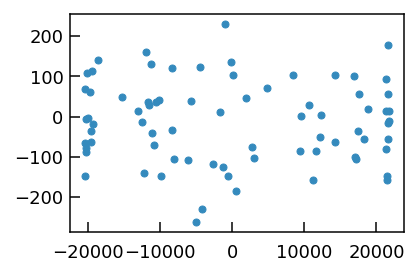

In [5]:
star_rvs = session.run(model.components[0].rvs_block[0])
initial_rvs = np.copy(star_rvs)
plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs)

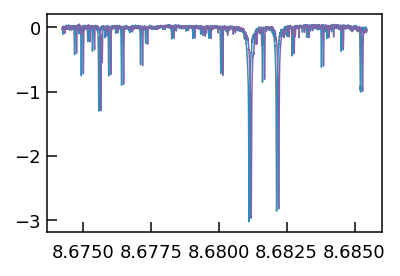

In [6]:
plt.plot(session.run(data.xs[0][0,:]), session.run(data.ys[0][0,:]))
plt.plot(session.run(data.xs[0][5,:]), session.run(data.ys[0][5,:]))

In [7]:
for c in model.components:
    c.initialize_model(0, data)
    session.run(tf.variables_initializer([c.model_xs[0], c.model_ys[0]]))

initializing star model...
initializing tellurics model...


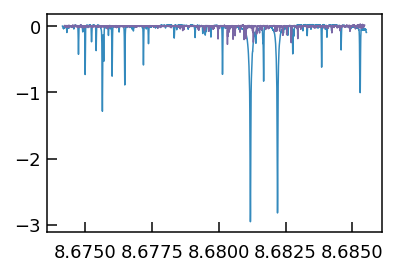

In [8]:
for c in model.components:
    model_xs = session.run(c.model_xs[0])
    model_ys = session.run(c.model_ys[0])
    plt.plot(model_xs, model_ys)

In [9]:
nll_history, rvs_history, model_history = wobble.optimize_order(model, data, 0, niter=80, output_history=True)

  0%|          | 0/80 [00:00<?, ?it/s]

--- ORDER 0 ---


100%|██████████| 80/80 [00:16<00:00,  4.91it/s]


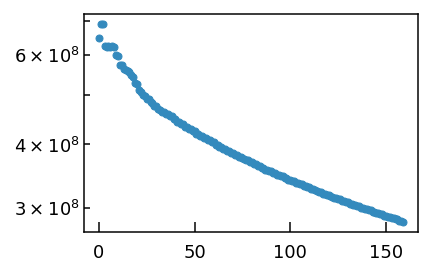

In [10]:
plt.scatter(np.arange(len(nll_history)), nll_history)
ax = plt.gca()
ax.set_yscale('log')

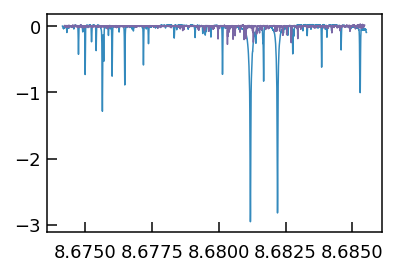

In [11]:
for c in model.components:
    model_xs = session.run(c.model_xs[0])
    model_ys = session.run(c.model_ys[0])
    plt.plot(model_xs, model_ys)

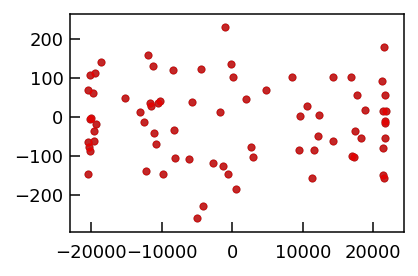

In [12]:
star_rvs = session.run(model.components[0].rvs_block[0])
plt.scatter(data.pipeline_rvs, initial_rvs + data.pipeline_rvs, color='k', alpha=0.6)
plt.scatter(data.pipeline_rvs, star_rvs + data.pipeline_rvs, color='r', alpha=0.6)

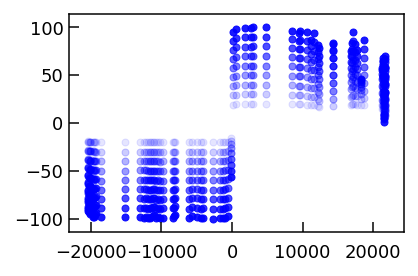

In [13]:
wobble.plot_rv_history(data, nll_history, rvs_history, model_history, 100)